## Import Libraries

In [1]:
import ast
import numpy as np 
import pandas as pd
import torch
from torchinfo import summary, ModelStatistics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from transformers import RobertaTokenizerFast, RobertaForTokenClassification, DataCollatorForTokenClassification
from tqdm.notebook import tqdm




## Preprocessing

In [2]:
df = pd.read_excel(r'/home/tensorboard/Documentos/D4R/7. Cazalla datasets/augmented BIONER/Cazalla_Augmented_BIONER_Religious.xlsx')
df = df.drop('Unnamed: 0', axis=1)
df = df.drop('Unnamed: 0.1', axis=1)

In [3]:
import ast
df['sentence'] = df['sentence'].apply(ast.literal_eval)
df.rename(columns={'sentence': 'tokens'}, inplace=True)
df['tags'] = df['tags'].apply(ast.literal_eval)

In [4]:
df

,tokens,tags,source
0,"[y, así, fue, mandado, volver, a, su, cárcel.,...","[O, O, O, O, O, O, O, O, O, O, B-rs]",GPT4-Augmented
1,"[estando, a, ello, presentes, ,, por, honestas...","[O, O, O, O, O, O, O, O, O, O, O, B-persName, ...",Original manuscript
2,"[y, que, ,, al, parecer, de, este, testigo, ,,...","[O, O, O, O, O, O, B-rs, I-rs, O, B-term, I-rs...",Original manuscript
3,"[y, lo, habrá, expresado, aunque, no, se, recu...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",GPT4-Augmented
4,"[y, no, se, acuerda, de, las, personas, que, s...","[O, O, O, O, O, O, O, O, O, O, O, B-persName, ...",Original manuscript
...,...,...,...
2792,"[y, que, la, ceremonia, le, ofrecía, en, agrad...","[O, O, O, O, O, O, O, O, O, O, O]",GPT4-Augmented
2793,"[y, que, todo, lo, demás, contenido, en, las, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-term, O...",Original manuscript
2794,"[y, que, antes, que, lo, hiciese, lo, había, c...","[O, O, O, O, O, O, O, O, O, O, O, B-persName, ...",GPT4-Augmented
2795,"[y, lo, diferente, porque, yo, siempre, he, te...","[O, O, B-rs, O, B-rs, O, O, O, O, O, O, O, O, ...",GPT4-Augmented


In [5]:
df.describe(include='all')

,tokens,tags,source
count,2797,2797,2797
unique,2546,2031,2
top,"[y, así, fue, mandado, volver, a, su, cárcel.,...","[O, O, O, O, O, O, O, O, O, O, B-rs]",Original manuscript
freq,8,105,1439


In [6]:
labels_to_ids = {'O': 0,
                 'B-persName':1,
                 'I-persName':2,
                 'B-date' :3,
                 'I-date': 4,
                 'B-placeName': 5,
                 'I-placeName':6,
                 'B-orgName': 7,
                 'I-orgName': 8,
                 'B-rs': 9,
                 'I-rs': 10,
                 'B-term': 11,
                 'I-term':12
                 }
ids_to_lables = {v:k for k, v in labels_to_ids.items()}

labels_list = [x for x in ids_to_lables.values()]

In [7]:
df['encoded_tags'] = df['tags'].apply(lambda tags: [labels_to_ids[tag] for tag in tags])
df.rename(columns={'tags': 'labels'}, inplace=True)
df.rename(columns={'encoded_tags': 'ner_tags'}, inplace=True)
df = df[['tokens', 'ner_tags', 'labels', 'source']]
df_test = df.drop('labels', axis=1)
df_test = df.drop('source', axis=1)
df_test =  df_test.drop('labels', axis=1)


In [8]:
type(df_test['ner_tags'][0])

list

In [9]:
input_column = 'tokens'
label_column = 'ner_tags'

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(df_test, test_size=0.2, random_state=42)



In [10]:
from transformers import BertTokenizerFast
model_test_name = 'PlanTL-GOB-ES/roberta-large-bne'

tokenizer = RobertaTokenizerFast.from_pretrained(model_test_name, add_prefix_space= True)

In [11]:
def tokenize_and_align_labels(dataframe, tokenizer):
    # Tokenize inputs using the provided tokenizer
    tokenized_inputs = tokenizer(dataframe['tokens'].tolist(),
                                 truncation=True,
                                   is_split_into_words=True,
                                     padding=True,max_length=150,
                                       return_tensors='pt',
                                         )

    labels = []
    for i, label in enumerate(dataframe['ner_tags'].tolist()):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    # Convert lists to PyTorch tensors
    tokenized_inputs["labels"] = torch.tensor(labels)

    return tokenized_inputs




In [12]:
import torch

def tokenize_and_align_labels(dataframe, tokenizer):
    # Tokenize inputs using the provided tokenizer
    tokenized_inputs = tokenizer(dataframe['tokens'].tolist(),
                                 truncation=True,
                                 is_split_into_words=True,
                                 padding=True,
                                 max_length=200,
                                 return_tensors='pt'
                                )

    labels = []
    for i, label in enumerate(dataframe['ner_tags'].tolist()):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                if word_idx < len(label):  # Check if the word index is within the range of the label list
                    label_ids.append(label[word_idx])
                else:
                    print(f"Word index {word_idx} exceeds label length for batch index {i}. Label length: {len(label)}")
                    label_ids.append(-100)  # Use -100 to mark as invalid
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    # Convert lists to PyTorch tensors
    tokenized_inputs["labels"] = torch.tensor(labels)

    return tokenized_inputs


In [13]:
tokenized_inputs_train = tokenize_and_align_labels(train_df, tokenizer)
tokenized_inputs_test = tokenize_and_align_labels(test_df, tokenizer)

Word index 32 exceeds label length for batch index 958. Label length: 32


In [14]:
tokenized_inputs_test['input_ids'].shape

torch.Size([560, 200])

## Transfer Learning Test

In [15]:

model =  RobertaForTokenClassification.from_pretrained(model_test_name, num_labels= len(labels_list),id2label=labels_to_ids, label2id=ids_to_lables)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/PlanTL-GOB-ES/roberta-large-bne/f032d2ce96a04934f8357476d8007be3606f347bb8e9fb446a66043dc588c677?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1708860068&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODg2MDA2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9QbGFuVEwtR09CLUVTL3JvYmVydGEtbGFyZ2UtYm5lL2YwMzJkMmNlOTZhMDQ5MzRmODM1NzQ3NmQ4MDA3YmUzNjA2ZjM0N2JiOGU5ZmI0NDZhNjYwNDNkYzU4OGM2Nzc%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=O8WBCUST4lcEJROPYIPF1IFvTtxnbpGObf-99lBkSF0-LA27PDoR3sAGZWVLeei-nlPySFryEZTp0uSwBIztKz5hPaNqk5X7%7EUPslE1FmhUaDSbAidc331YkI-d88nilbgUNoYnm2Mu76yf786TukHtX0m2IF0Vi5V1xxUU19idEUbb%7EL2oLLmlZ9rY1ucw3omDki1TtxoUpyaT7LPXywGeoTu-i3Oyw-Xh9MUS6QvVLWQQ7szTxhcSlvX8Z2y73uVeo7u

pytorch_model.bin:  25%|##5       | 357M/1.42G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/PlanTL-GOB-ES/roberta-large-bne/f032d2ce96a04934f8357476d8007be3606f347bb8e9fb446a66043dc588c677?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1708860068&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODg2MDA2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9QbGFuVEwtR09CLUVTL3JvYmVydGEtbGFyZ2UtYm5lL2YwMzJkMmNlOTZhMDQ5MzRmODM1NzQ3NmQ4MDA3YmUzNjA2ZjM0N2JiOGU5ZmI0NDZhNjYwNDNkYzU4OGM2Nzc%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=O8WBCUST4lcEJROPYIPF1IFvTtxnbpGObf-99lBkSF0-LA27PDoR3sAGZWVLeei-nlPySFryEZTp0uSwBIztKz5hPaNqk5X7%7EUPslE1FmhUaDSbAidc331YkI-d88nilbgUNoYnm2Mu76yf786TukHtX0m2IF0Vi5V1xxUU19idEUbb%7EL2oLLmlZ9rY1ucw3omDki1TtxoUpyaT7LPXywGeoTu-i3Oyw-Xh9MUS6QvVLWQQ7szTxhcSlvX8Z2y73uVeo7u

pytorch_model.bin:  64%|######4   | 912M/1.42G [00:00<?, ?B/s]

Error while downloading from https://cdn-lfs.huggingface.co/PlanTL-GOB-ES/roberta-large-bne/f032d2ce96a04934f8357476d8007be3606f347bb8e9fb446a66043dc588c677?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1708860068&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODg2MDA2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9QbGFuVEwtR09CLUVTL3JvYmVydGEtbGFyZ2UtYm5lL2YwMzJkMmNlOTZhMDQ5MzRmODM1NzQ3NmQ4MDA3YmUzNjA2ZjM0N2JiOGU5ZmI0NDZhNjYwNDNkYzU4OGM2Nzc%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=O8WBCUST4lcEJROPYIPF1IFvTtxnbpGObf-99lBkSF0-LA27PDoR3sAGZWVLeei-nlPySFryEZTp0uSwBIztKz5hPaNqk5X7%7EUPslE1FmhUaDSbAidc331YkI-d88nilbgUNoYnm2Mu76yf786TukHtX0m2IF0Vi5V1xxUU19idEUbb%7EL2oLLmlZ9rY1ucw3omDki1TtxoUpyaT7LPXywGeoTu-i3Oyw-Xh9MUS6QvVLWQQ7szTxhcSlvX8Z2y73uVeo7u

pytorch_model.bin:  95%|#########5| 1.35G/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
from torch.nn import Linear
for param in model.parameters():
    param.requires_grad = False
# Create a new linear layer for NER
new_classifier = Linear(in_features=model.config.hidden_size, out_features=model.config.num_labels)

# Replace the existing classifier with the new one
model.classifier = new_classifier

In [17]:
input_ids = torch.randint(0, model.config.vocab_size, (1, 128))
attention_mask = torch.ones((1, 128))

        # Get the model summary
summary(model,
            input_data=input_ids,
                       col_names=["input_size", "output_size", "num_params", "trainable"],
                       )

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
RobertaForTokenClassification                                [1, 128]                  [1, 128, 13]              --                        Partial
├─RobertaModel: 1-1                                          [1, 128]                  [1, 128, 1024]            --                        False
│    └─RobertaEmbeddings: 2-1                                --                        [1, 128, 1024]            --                        False
│    │    └─Embedding: 3-1                                   [1, 128]                  [1, 128, 1024]            (51,468,288)              False
│    │    └─Embedding: 3-2                                   [1, 128]                  [1, 128, 1024]            (1,024)                   False
│    │    └─Embedding: 3-3                                   [1, 128]                  [1, 128, 1024]            (526,336)  

In [18]:
class baseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [19]:
dataset_train= baseDataset(tokenized_inputs_train)
dataset_test =baseDataset(tokenized_inputs_test)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=48, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=24, shuffle=True)

In [20]:
optimizer= torch.optim.AdamW(model.parameters(), lr=5e-5)

In [21]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [22]:
model.to(device)
model.train()

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
    

In [23]:
from tqdm.notebook import tqdm
epochs = 6
train_losses = []
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optimizer.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids,
                        attention_mask=attention_mask,
                        #token_type_ids=token_type_ids,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optimizer.step()
        # print relevant info to progress bar
        train_losses.append(loss.item())
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

# Testing loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
all_labels_flat = np.concatenate(all_labels)
all_preds_flat = np.concatenate(all_preds)

# Filter out instances with label -100
valid_indices = all_labels_flat != -100
all_labels_filtered = all_labels_flat[valid_indices]
all_preds_filtered = all_preds_flat[valid_indices]

# Calculate metrics
f1 = f1_score(all_labels_filtered, all_preds_filtered, average='micro',zero_division='warn' )
classification_report_str = classification_report(all_labels_filtered, all_preds_filtered, target_names=labels_list)
# Print or log the metrics
print(f'Micro F1 Score: {f1}')
print('Classification Report:')
print(classification_report_str)

with open('text_metrics_Roberta-large-TL.txt', 'w', encoding='utf-8') as f:
    f.write(f'Micro F1 Score {f1}')
    f.write(f'Classification Report for Roberta-large-TL NER:\n{classification_report_str}')
    f.close()

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

Micro F1 Score: 0.7977212423911347
Classification Report:
              precision    recall  f1-score   support

           O       0.80      1.00      0.89     20249
  B-persName       0.00      0.00      0.00       730
  I-persName       0.95      0.17      0.29       982
      B-date       0.00      0.00      0.00        41
      I-date       0.00      0.00      0.00       347
 B-placeName       0.00      0.00      0.00       178
 I-placeName       0.00      0.00      0.00        43
   B-orgName       0.00      0.00      0.00        82
   I-orgName       0.00      0.00      0.00       137
        B-rs       0.00      0.00      0.00       757
        I-rs       0.00      0.00      0.00       634
      B-term       1.00      0.02      0.05      1265
      I-term       0.00      0.00      0.00       183

    accuracy                           0.80     25628
   macro avg       0.21      0.09      0.09     25628
weighted avg       0.72      0.80      0.71     25628



/home/tensorboard/Documentos/D4R/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tensorboard/Documentos/D4R/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tensorboard/Documentos/D4R/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

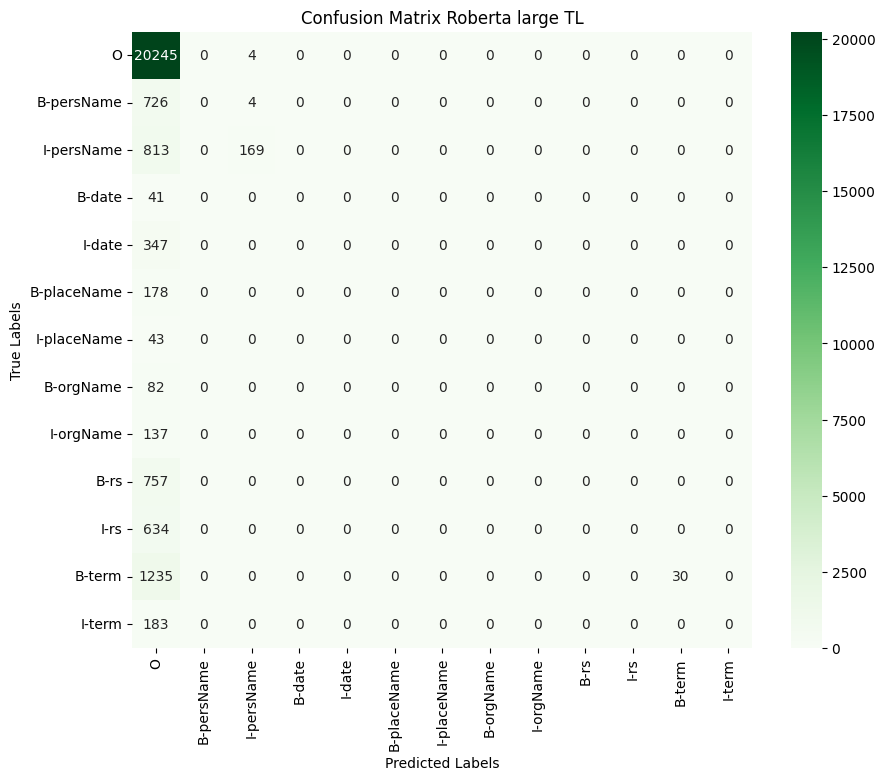

<Figure size 640x480 with 0 Axes>

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(all_labels_filtered, all_preds_filtered)

# Plot the confusion matrix using Seaborn heatmap
labels_names = [ids_to_lables[label_id] for label_id in all_labels_filtered]
preds_names = [ids_to_lables[label_id] for label_id in all_preds_filtered]

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_names, preds_names, labels=list(ids_to_lables.values()))

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=list(ids_to_lables.values()), yticklabels=list(ids_to_lables.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Roberta large TL')
plt.show()
plt.savefig('Confusion Matrix Roberta large TL.png')

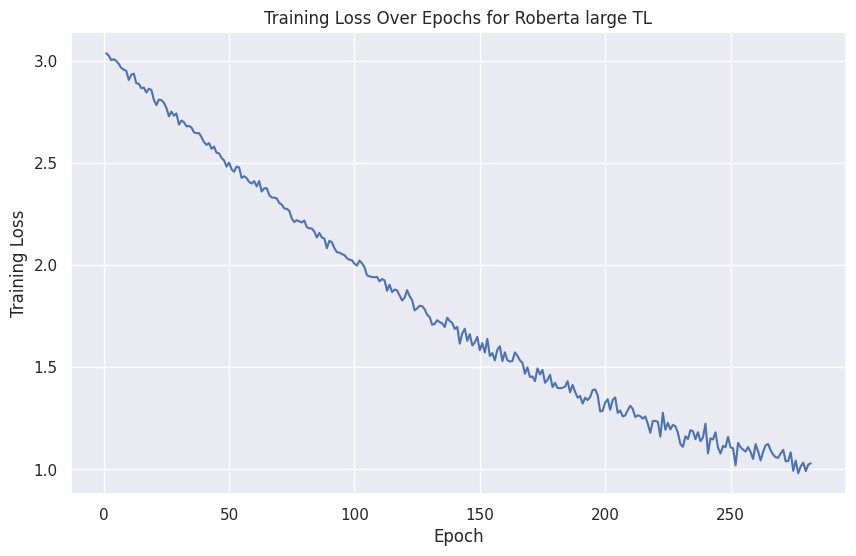

<Figure size 640x480 with 0 Axes>

In [25]:
# Plot the training loss over epochs
sns.set()
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs for Roberta large TL')
plt.show()
plt.savefig('Training Loss Over Epochs for Roberta large TL.png')

In [26]:
model.save_pretrained('RoBERTa-Large-cazalla-NER-Transfer-learning')

## Fully Pretrainned

In [15]:

model =  RobertaForTokenClassification.from_pretrained(model_test_name, num_labels= len(labels_list),id2label=labels_to_ids, label2id=ids_to_lables)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-large-bne and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
input_ids = torch.randint(0, model.config.vocab_size, (1, 128))
attention_mask = torch.ones((1, 128))

        # Get the model summary
summary(model,
            input_data=input_ids,
                       col_names=["input_size", "output_size", "num_params", "trainable"],
                       )

Layer (type:depth-idx)                                       Input Shape               Output Shape              Param #                   Trainable
RobertaForTokenClassification                                [1, 128]                  [1, 128, 13]              --                        True
├─RobertaModel: 1-1                                          [1, 128]                  [1, 128, 1024]            --                        True
│    └─RobertaEmbeddings: 2-1                                --                        [1, 128, 1024]            --                        True
│    │    └─Embedding: 3-1                                   [1, 128]                  [1, 128, 1024]            51,468,288                True
│    │    └─Embedding: 3-2                                   [1, 128]                  [1, 128, 1024]            1,024                     True
│    │    └─Embedding: 3-3                                   [1, 128]                  [1, 128, 1024]            526,336           

In [17]:
class baseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [18]:
dataset_train= baseDataset(tokenized_inputs_train)
dataset_test =baseDataset(tokenized_inputs_test)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=24, shuffle=True)

In [19]:
optimizer= torch.optim.AdamW(model.parameters(), lr=5e-5)

In [20]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [21]:
model.to(device)
model.train()

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50262, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
    

In [22]:
from tqdm.notebook import tqdm
epochs = 6
train_losses = []
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        # initialize calculated gradients (from prev step)
        optimizer.zero_grad()
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids,
                        attention_mask=attention_mask,
                        #token_type_ids=token_type_ids,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        # calculate loss for every parameter that needs grad update
        loss.backward()
        # update parameters
        optimizer.step()
        # print relevant info to progress bar
        train_losses.append(loss.item())
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())


        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

# Testing loop
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        #token_type_ids = batch['token_type_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
all_labels_flat = np.concatenate(all_labels)
all_preds_flat = np.concatenate(all_preds)

# Filter out instances with label -100
valid_indices = all_labels_flat != -100
all_labels_filtered = all_labels_flat[valid_indices]
all_preds_filtered = all_preds_flat[valid_indices]

# Calculate metrics
f1 = f1_score(all_labels_filtered, all_preds_filtered, average='micro',zero_division='warn' )
classification_report_str = classification_report(all_labels_filtered, all_preds_filtered, target_names=labels_list)
# Print or log the metrics
print(f'Micro F1 Score: {f1}')
print('Classification Report:')
print(classification_report_str)

with open('text_metrics_Roberta-large-Full.txt', 'w', encoding='utf-8') as f:
    f.write(f'Micro F1 Score {f1}')
    f.write(f'Classification Report for Roberta-large-Full NER:\n{classification_report_str}')
    f.close()

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

  0%|          | 0/560 [00:00<?, ?it/s]

Micro F1 Score: 0.9597705634462307
Classification Report:
              precision    recall  f1-score   support

           O       0.99      0.97      0.98     20249
  B-persName       0.91      0.96      0.94       730
  I-persName       0.98      0.94      0.96       982
      B-date       0.86      0.93      0.89        41
      I-date       0.90      0.99      0.94       347
 B-placeName       0.78      0.98      0.87       178
 I-placeName       0.38      0.91      0.54        43
   B-orgName       0.82      0.84      0.83        82
   I-orgName       0.89      0.77      0.83       137
        B-rs       0.91      0.91      0.91       757
        I-rs       0.95      0.93      0.94       634
      B-term       0.88      0.95      0.92      1265
      I-term       0.28      0.63      0.38       183

    accuracy                           0.96     25628
   macro avg       0.81      0.90      0.84     25628
weighted avg       0.97      0.96      0.96     25628



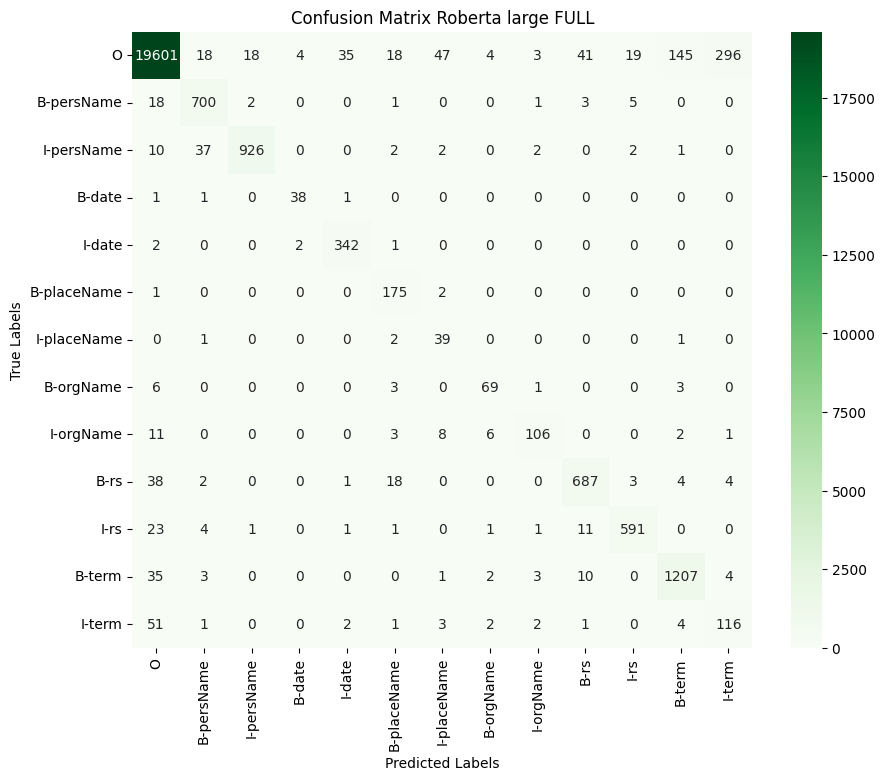

<Figure size 640x480 with 0 Axes>

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(all_labels_filtered, all_preds_filtered)

# Plot the confusion matrix using Seaborn heatmap
labels_names = [ids_to_lables[label_id] for label_id in all_labels_filtered]
preds_names = [ids_to_lables[label_id] for label_id in all_preds_filtered]

# Compute confusion matrix
conf_matrix = confusion_matrix(labels_names, preds_names, labels=list(ids_to_lables.values()))

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=list(ids_to_lables.values()), yticklabels=list(ids_to_lables.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Roberta large FULL')
plt.show()
plt.savefig('Confusion Matrix Roberta large FULL.png')

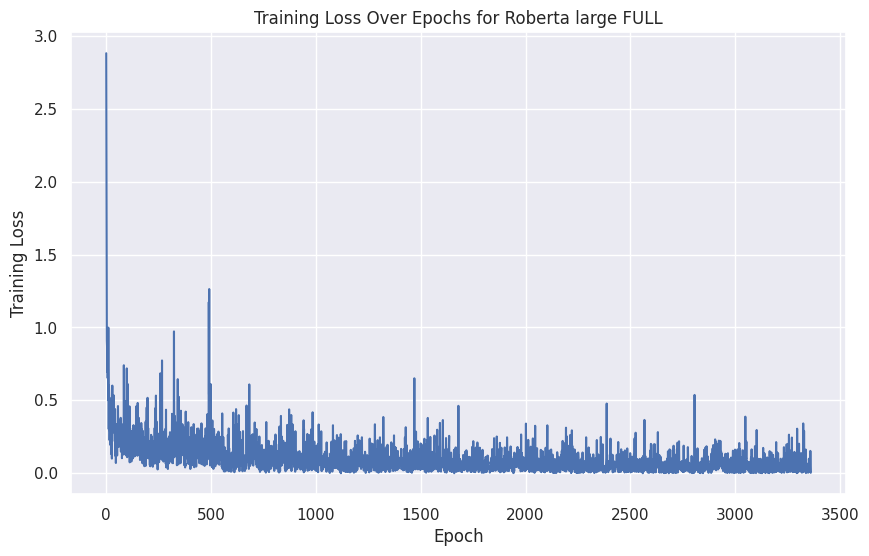

<Figure size 640x480 with 0 Axes>

In [24]:
# Plot the training loss over epochs
sns.set()
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs for Roberta large FULL')
plt.show()
plt.savefig('Training Loss Over Epochs for Roberta large FULL.png')

In [ ]:
model.save_pretrained('RoBERTa-Large-cazalla-NER-Fully.png')